In [9]:
import os
print(os.getcwd()) 

C:\Users\jaanh\Notebooks\dataquest


In [37]:
import pandas as pd
path = "train_data/train_data.csv"
df = pd.read_csv(path)

## 1. Dealing with Missing Values  
- **Categorical Features**: Filled with **mode**.  
- **Continuous Features**:  
  - If **highly skewed** → filled with **median**.  
  - If **normally distributed or mildly skewed** → filled with **mean**.  

---

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
def impute_missing_values(df):
    for col in df.columns:
        if col in categorical_features:
            # Mode imputation for categorical variables
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            # Determine skewness
            skewness = df[col].skew()
            if abs(skewness) > 1:  # Highly skewed → Use median
                df[col].fillna(df[col].median(), inplace=True)
            else:  # Normal or mild skewness → Use mean
                df[col].fillna(df[col].mean(), inplace=True)
    return df

data_cleaned = impute_missing_values(df)


C:\Users\jaanh\AppData\Local\Temp\ipykernel_26532\237101676.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\jaanh\AppData\Local\Temp\ipykernel_26532\237101676.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [47]:
print(data_cleaned.isnull().sum())

account_number             0
bad_flag                   0
onus_attribute_1           0
transaction_attribute_1    0
transaction_attribute_2    0
                          ..
onus_attribute_44          0
onus_attribute_45          0
onus_attribute_46          0
onus_attribute_47          0
onus_attribute_48          0
Length: 1216, dtype: int64


## 2. Feature Engineering  

### **Step 1: Removing Highly Correlated Features**  
- Created a **balanced subset** of data.  
- Computed **correlation matrix** to remove highly correlated features.  
- **Features removed**: `599`  
- **Remaining features**: `617`  


In [65]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Balance the dataset by downsampling the majority class
def balance_data(df, target_col):
    min_class_size = df[target_col].value_counts().min()
    balanced_df = pd.concat([
        resample(df[df[target_col] == cls], n_samples=min_class_size, replace=False, random_state=42)
        for cls in df[target_col].unique()
    ])
    return balanced_df.sample(frac=1, random_state=42)  # Shuffle data

# Assuming 'target' is the label column
balanced_data = balance_data(data_cleaned, target_col='bad_flag')

# Apply correlation-based feature selection
corr_threshold = 0.85
corr_matrix = balanced_data.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]

# Drop highly correlated features
train_data = balanced_data.drop(columns=high_corr_features)

print(f"Removed {len(high_corr_features)} highly correlated features.")
print(f"Remaining features: {train_data.shape[1]}")

Removed 599 highly correlated features.
Remaining features: 617


### **Step 2: Variance Thresholding**  
- Applied **variance threshold** to further eliminate low-variance features.  
- **Remaining features**: `427` 

In [71]:
from sklearn.feature_selection import VarianceThreshold

# Dropping the target column first
X = data_cleaned.drop(columns=['bad_flag'])

# Dropping highly correlated features (assuming high_corr_features is a list of column names)
X = X.drop(columns=high_corr_features)

# Target variable
y = data_cleaned['bad_flag']

# Applying Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)

# Get selected feature names
selected_features = X.columns[selector.get_support()]

# Convert to DataFrame
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

print(f"Original Features: {X.shape[1]}, Selected Features: {X_selected_df.shape[1]}")


C:\Users\jaanh\anaconda3\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:112: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Original Features: 616, Selected Features: 427


In [73]:
X_selected_df.head()

,account_number,onus_attribute_1,transaction_attribute_1,transaction_attribute_4,transaction_attribute_5,transaction_attribute_7,transaction_attribute_9,transaction_attribute_10,transaction_attribute_11,transaction_attribute_13,...,bureau_enquiry_28,bureau_enquiry_32,bureau_enquiry_34,bureau_enquiry_35,bureau_enquiry_36,bureau_enquiry_38,bureau_enquiry_48,onus_attribute_43,onus_attribute_44,onus_attribute_47
0,47642.0,100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,95032.0,108000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0
2,40510.0,61000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0
3,51692.0,469000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27459.0,152000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### **Step 3: XGBoost Feature Selection**  
- Used **XGBoost feature importance** to further refine feature selection.  
- **Final selected features**: `58`  

In [77]:
%pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 393.8 kB/s eta 0:06:21
   ---------------------------------------- 0.1/150.0 MB 819.2 kB/s eta 0:03:03
   ---------------------------------------- 0.2/150.0 MB 952.6 kB/s eta 0:02:38
   ---------------------------------------- 0.3/150.0 MB 1.3 MB/s eta 0:01:58
   ---------------------------------------- 0.5/150.0 MB 1.5 MB/s eta 0:01:41
   ---------------------------------------- 0.6/150.0 MB 1.7 MB/s eta 0:01:27
   ---------------------------------------- 0.7/150.0 MB 1.9 MB/s eta 0:01:20
   ---------------------------------------- 0.9/150.0 MB 2.0 MB/s eta 0:01:16
   ---------------------------------------- 1.0/150.0 MB 2.1 MB/s eta 0:01:12
   ---------------------------------------- 1.1/150.0 MB 2.1 MB/s eta 0:01:11
   ---------------------------------------- 1.4/150.0 MB 2.3 MB/s eta 0:

In [79]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
X = X.drop(columns=selected_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.1, 
    tree_method='gpu_hist'  # Change to 'gpu_hist' if using GPU
)
model.fit(X_train, y_train)

# Select Important Features
selector = SelectFromModel(model, threshold="mean", prefit=True)
X_selected = selector.transform(X)

selected_features = pd.DataFrame(X, columns=X.columns[selector.get_support()])
print(f"Original Features: {X.shape[1]}, Selected Features: {selected_features.shape[1]}")


C:\Users\jaanh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:50:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


Original Features: 189, Selected Features: 58


C:\Users\jaanh\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\jaanh\anaconda3\Lib\site-packages\xgboost\sklearn.py:1478: UserWarning: [20:50:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  score = b.get_score(


In [81]:
selected_features.head()

,transaction_attribute_121,transaction_attribute_122,transaction_attribute_130,transaction_attribute_134,transaction_attribute_169,transaction_attribute_184,transaction_attribute_187,transaction_attribute_199,transaction_attribute_203,transaction_attribute_204,...,bureau_180,bureau_185,bureau_203,bureau_209,bureau_210,bureau_213,bureau_239,bureau_449,onus_attribute_3,bureau_enquiry_9
0,0.0,0.008107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.001921,0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0.0


In [88]:
selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77444 entries, 0 to 77443
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_attribute_121  77444 non-null  float64
 1   transaction_attribute_122  77444 non-null  float64
 2   transaction_attribute_130  77444 non-null  float64
 3   transaction_attribute_134  77444 non-null  float64
 4   transaction_attribute_169  77444 non-null  float64
 5   transaction_attribute_184  77444 non-null  float64
 6   transaction_attribute_187  77444 non-null  float64
 7   transaction_attribute_199  77444 non-null  float64
 8   transaction_attribute_203  77444 non-null  float64
 9   transaction_attribute_204  77444 non-null  float64
 10  transaction_attribute_207  77444 non-null  float64
 11  transaction_attribute_210  77444 non-null  float64
 12  transaction_attribute_212  77444 non-null  float64
 13  transaction_attribute_213  77444 non-null  flo

In [92]:
final_data = pd.concat([selected_features, y], axis=1)

In [94]:
final_data.head()

,transaction_attribute_121,transaction_attribute_122,transaction_attribute_130,transaction_attribute_134,transaction_attribute_169,transaction_attribute_184,transaction_attribute_187,transaction_attribute_199,transaction_attribute_203,transaction_attribute_204,...,bureau_185,bureau_203,bureau_209,bureau_210,bureau_213,bureau_239,bureau_449,onus_attribute_3,bureau_enquiry_9,bad_flag
0,0.0,0.008107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0.0,0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018963,...,0.0,0.0,0.0,0.0,0.0,0.0,1.001921,0,0.0,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0.0,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0.0,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,0.0,0


## 3. Distribution of Data  
- **Visualizations** were created to analyze class distribution.  
- Found the dataset to be **highly imbalanced**. 

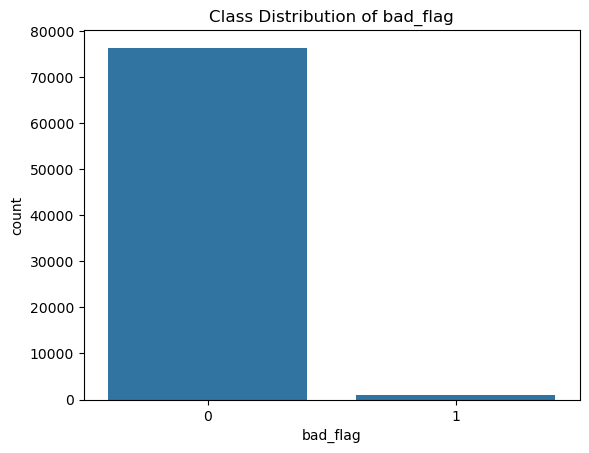

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="bad_flag", data=final_data)
plt.title("Class Distribution of bad_flag")
plt.show()

In [98]:
bad_count = df[df['bad_flag'] == 1].shape[0]
good_count = df[df['bad_flag'] == 0].shape[0]

print(f"Bad Flag (Defaults): {bad_count}")
print(f"Good Flag (Non-Defaults): {good_count}")

Bad Flag (Defaults): 1102
Good Flag (Non-Defaults): 76342


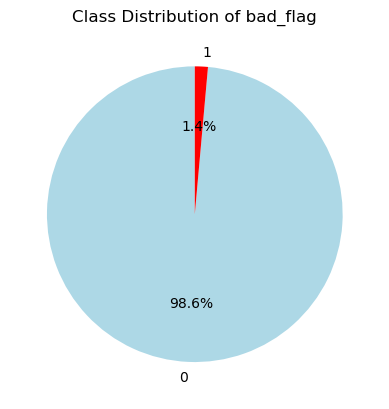

In [100]:
final_data["bad_flag"].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, colors=["lightblue", "red"])
plt.title("Class Distribution of bad_flag")
plt.ylabel("")
plt.show()


## 4. Undersampling Methods  

To address class imbalance, three different undersampling strategies were applied:

### **Dataset 1 (Mildly Imbalanced, Noisy Points Removed)**  
**Steps Taken:**  
1. **Tomek Links** – Removed majority class samples close to minority class.  
2. **Edited Nearest Neighbors (ENN)** – Removed noisy samples.  
3. **Random Undersampling** – Reduced majority class count while keeping some imbalance.  

**Final Distribution:**  
- **Class 0 (Majority)**: `11,020`  
- **Class 1 (Minority)**: `1,102`  

In [102]:
from imblearn.under_sampling import TomekLinks
import pandas as pd


In [106]:
tomek = TomekLinks(sampling_strategy="majority")  # Remove majority class Tomek links
X_resampled, y_resampled = tomek.fit_resample(selected_features, y)
df_resampled = pd.DataFrame(X_resampled, columns=selected_features.columns)
df_resampled["bad_flag"] = y_resampled
print(df_resampled["bad_flag"].value_counts())

bad_flag
0    76092
1     1102
Name: count, dtype: int64


In [110]:
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter

enn = EditedNearestNeighbours(n_neighbors=3)  
X_new=df_resampled.drop(columns='bad_flag')
X_resampled, y_resampled = enn.fit_resample(X_new, df_resampled["bad_flag"])

print(Counter(y_resampled))

Counter({0: 74324, 1: 1102})


In [128]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)  
X3, y3 = rus.fit_resample(X_resampled, y_resampled)

from collections import Counter
print(Counter(y3))  # Check the new distribution


Counter({0: 11020, 1: 1102})


In [130]:
X3.head()

,transaction_attribute_121,transaction_attribute_122,transaction_attribute_130,transaction_attribute_134,transaction_attribute_169,transaction_attribute_184,transaction_attribute_187,transaction_attribute_199,transaction_attribute_203,transaction_attribute_204,...,bureau_180,bureau_185,bureau_203,bureau_209,bureau_210,bureau_213,bureau_239,bureau_449,onus_attribute_3,bureau_enquiry_9
18838,0.0,0.008107,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0
26915,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0
30862,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0
5879,0.0,0.000000,0.0,0.127362,0.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0
14926,0.0,0.008107,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0



### **Dataset 2 (Perfectly Balanced using Cluster Centroids)**  
- Used **ClusterCentroids** to generate synthetic minority samples.  
- **Final Distribution:**  
  - **Class 0**: `1,102`  
  - **Class 1**: `1,102`  


In [118]:
from imblearn.under_sampling import ClusterCentroids
from collections import Counter

cc = ClusterCentroids(random_state=42)  # Keeps representative majority samples
X2, y2 = cc.fit_resample(X_resampled, y_resampled)

print(Counter(y2))  # Check new class distribution
  # See how much data remains


Counter({0: 1102, 1: 1102})


### **Training on Dataset 1 (Mildly Imbalanced)**  
- Model: **Balanced Random Forest** (BRF)  
- Used **class weighting** to handle imbalance.  
- **Oversampling performed** to increase the minority class count:  
  - **Final Distribution:** `Counter({0: 11,020, 1: 5,510})`  
- **Evaluation Metrics Captured.**  


In [162]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Increase minority class to 50% of majority
X_balanced, y_balanced = smote.fit_resample(X3, y3)
print(Counter(y_balanced))  # Check new class distribution

Counter({0: 11020, 1: 5510})


In [178]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced) 
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Balanced Random Forest
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)

# Predictions
y_pred = brf.predict(X_test)
y_prob = brf.predict_proba(X_test)[:, 1]  # For AUC-ROC

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


C:\Users\jaanh\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\jaanh\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\jaanh\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Accuracy: 0.7626
Precision: 0.6261
Recall: 0.7142
F1-score: 0.6672
ROC-AUC: 0.8503

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      2204
           1       0.63      0.71      0.67      1102

    accuracy                           0.76      3306
   macro avg       0.74      0.75      0.74      3306
weighted avg       0.77      0.76      0.77      3306



### **Training on Dataset 2 (Cluster Centroids - Fully Balanced)**  
- Model: **Balanced Random Forest** (BRF)  
- **Results showed significant improvement.**  
- **Evaluation Metrics Captured.**  

In [166]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

# Balanced Random Forest
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)

# Predictions
y_pred = brf.predict(X_test)
y_prob = brf.predict_proba(X_test)[:, 1]  # For AUC-ROC

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


C:\Users\jaanh\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\jaanh\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\jaanh\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Accuracy: 0.9025
Precision: 0.9041
Recall: 0.9000
F1-score: 0.9021
ROC-AUC: 0.9663

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       221
           1       0.90      0.90      0.90       220

    accuracy                           0.90       441
   macro avg       0.90      0.90      0.90       441
weighted avg       0.90      0.90      0.90       441



In [202]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X3)

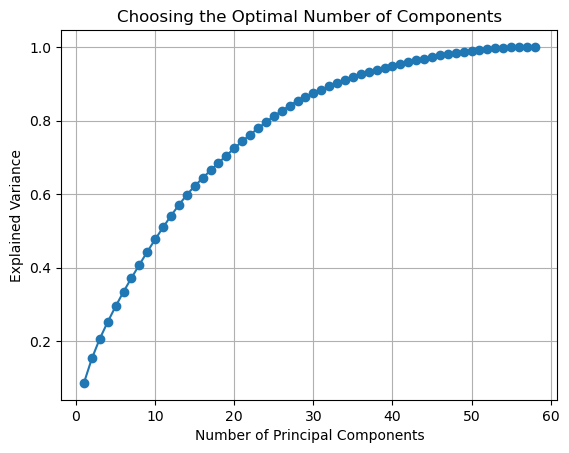

In [204]:
pca_full = PCA().fit(X3)
explained_variance = pca_full.explained_variance_ratio_

import numpy as np
cumulative_variance = np.cumsum(explained_variance)  # Cumulative sum of variance

import matplotlib.pyplot as plt
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Choosing the Optimal Number of Components')
plt.grid()
plt.show()

In [206]:
pca_optimal = PCA(n_components=0.95)  # Keep 95% of variance
X_pca_opt = pca_optimal.fit_transform(X_scaled)

print(f"Reduced feature count: {X_pca_opt.shape[1]}")  # Check new feature count

Reduced feature count: 45


In [208]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

In [214]:
print(len(X_pca))

12122


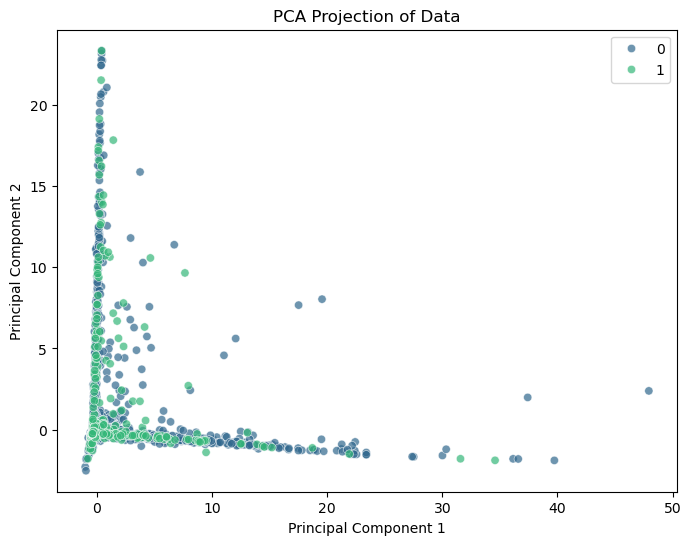

In [216]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y3, palette='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Data')
plt.legend()
plt.show()


In [220]:
%pip install umap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3552 sha256=4eaee3e7579d19fbf17c2d0751f6091c658220291d36c451a3fd1e846eeca808
  Stored in directory: c:\users\jaanh\appdata\local\pip\cache\wheels\48\4a\1c\1d511cbb0413a448d8546e958f8e82b98d9bb493038d19ece2
Successfully built umap
Note: you may need to restart the kernel to use updated packages.


In [231]:
%pip install umap-learn


   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ------------------------------------ --- 81.9/88.8 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 88.8/88.8 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 2.9 MB/s eta 0:00:00


C:\Users\jaanh\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\jaanh\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


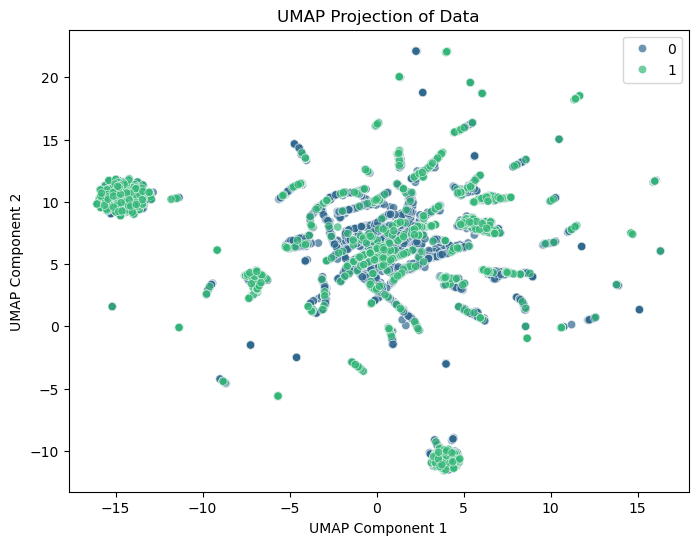

In [235]:
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Plot UMAP result
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y3, palette='viridis', alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Data')
plt.legend()
plt.show()

C:\Users\jaanh\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


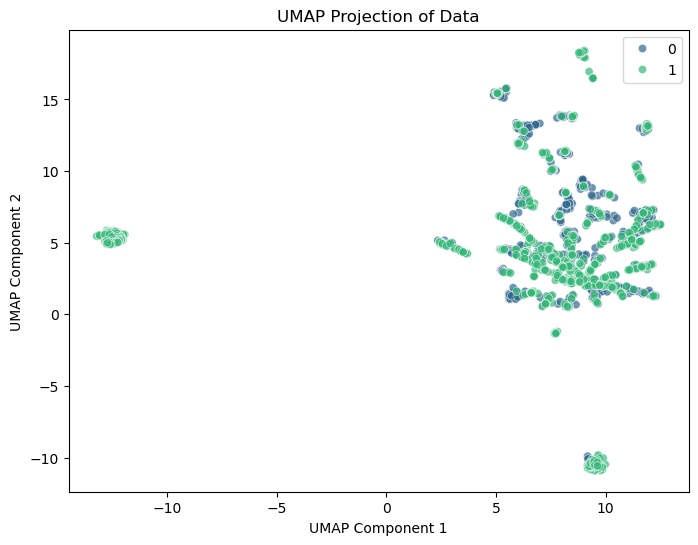

In [241]:
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X2)

# Plot UMAP result
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y2, palette='viridis', alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Data')
plt.legend()
plt.show()

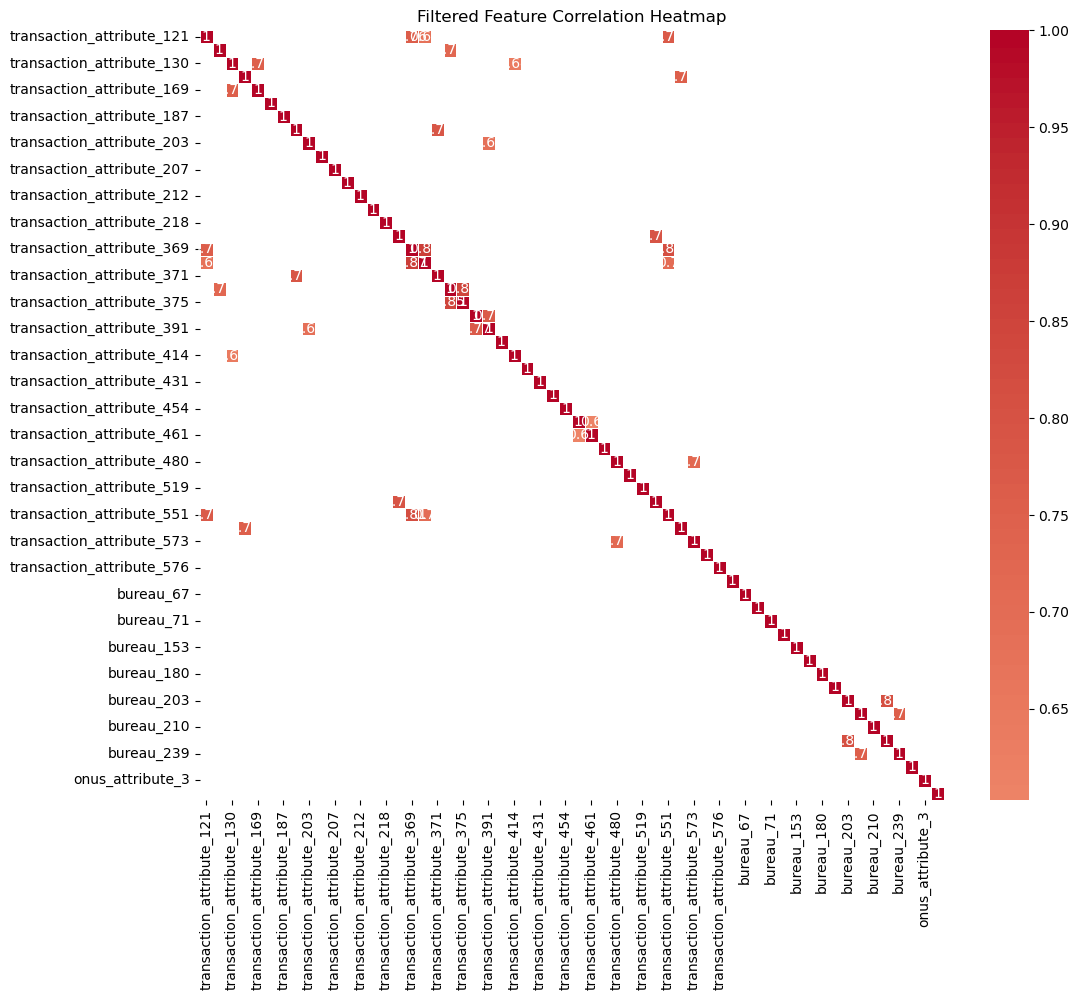

In [249]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute correlation matrix
corr_matrix = pd.DataFrame(X3).corr()

# Set a threshold (e.g., |correlation| > 0.6)
mask = np.abs(corr_matrix) < 0.6

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, mask=mask, linewidths=0.5)
plt.title("Filtered Feature Correlation Heatmap")
plt.show()


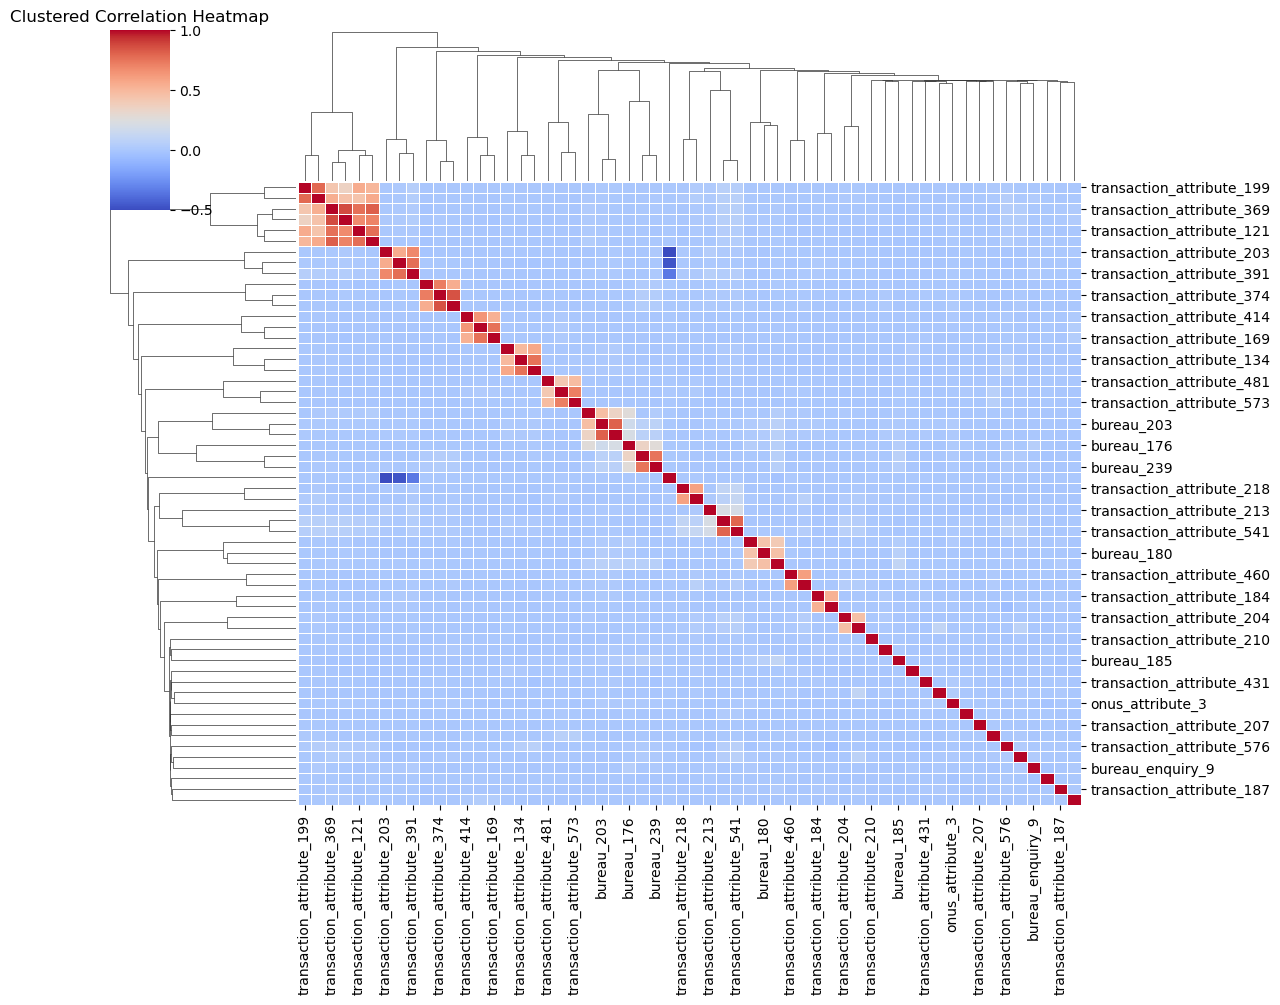

In [251]:
sns.clustermap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5, figsize=(12, 10))
plt.title("Clustered Correlation Heatmap")
plt.show()

In [265]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
labels = iso.fit_predict(X2)

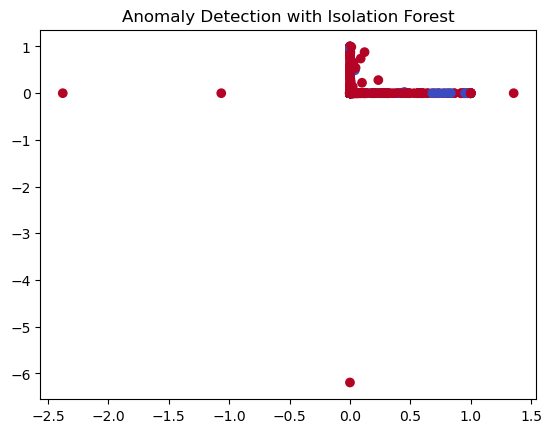

In [267]:
import matplotlib.pyplot as plt  
plt.scatter(X2.iloc[:, 0], X2.iloc[:, 1], c=labels, cmap="coolwarm")

plt.title("Anomaly Detection with Isolation Forest")  
plt.show()

In [269]:
anomalies = X2[labels == -1]  # Extract anomaly data points
print(anomalies)

      transaction_attribute_121  transaction_attribute_122  \
3                  6.072755e-01                        0.0   
24                 3.469447e-18                        0.0   
27                 5.358145e-03                        0.0   
96                 3.469447e-18                        0.0   
107                0.000000e+00                        0.0   
...                         ...                        ...   
1661               1.000000e+00                        0.0   
1711               2.612633e-02                        0.0   
1921               0.000000e+00                        0.0   
2134               0.000000e+00                        0.0   
2163               0.000000e+00                        0.0   

      transaction_attribute_130  transaction_attribute_134  \
3                      0.000000                   0.006417   
24                     0.908076                   0.003095   
27                     0.000000                   0.000000   
96     

In [271]:
import numpy as np  
anomaly_means = np.mean(anomalies, axis=0)  
dataset_means = np.mean(X2, axis=0)  
difference = anomaly_means - dataset_means  
print(difference)  # W

transaction_attribute_121    0.198996
transaction_attribute_122    0.016514
transaction_attribute_130    0.068628
transaction_attribute_134   -0.023835
transaction_attribute_169    0.066866
transaction_attribute_184   -0.007856
transaction_attribute_187   -0.005398
transaction_attribute_199    0.110104
transaction_attribute_203    0.003623
transaction_attribute_204    0.012787
transaction_attribute_207   -0.008117
transaction_attribute_210   -0.019574
transaction_attribute_212   -0.007385
transaction_attribute_213   -0.006354
transaction_attribute_218    0.037350
transaction_attribute_233    0.044528
transaction_attribute_369    0.226803
transaction_attribute_370    0.170650
transaction_attribute_371    0.124992
transaction_attribute_374    0.037282
transaction_attribute_375    0.025655
transaction_attribute_389    0.053662
transaction_attribute_391    0.006973
transaction_attribute_396   -0.002270
transaction_attribute_414    0.093266
transaction_attribute_421   -0.004926
transaction_

In [275]:
anomaly_deviation = anomalies.mean() - X3.mean()
top_contributors = anomaly_deviation.abs().sort_values(ascending=False)
print(top_contributors.head(10))

bureau_203                   0.300532
transaction_attribute_369    0.271151
bureau_176                   0.254744
bureau_239                   0.244250
bureau_213                   0.239448
bureau_210                   0.233756
transaction_attribute_121    0.221081
bureau_209                   0.220688
transaction_attribute_370    0.214760
bureau_153                   0.213659
dtype: float64


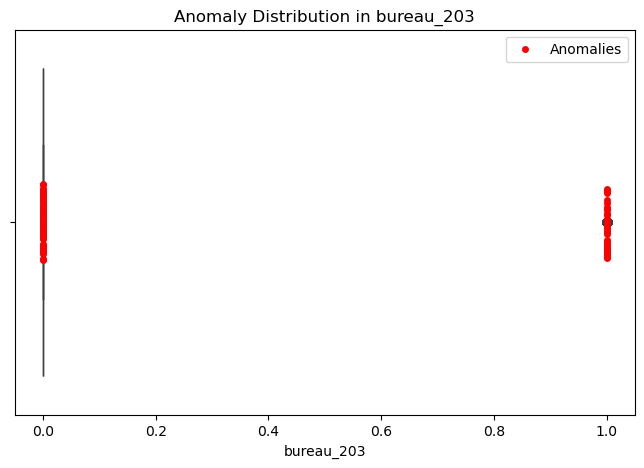

In [277]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top anomaly-driving feature
top_feature = top_contributors.index[0]

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=X, x=top_feature)
sns.stripplot(data=anomalies, x=top_feature, color="red", label="Anomalies", jitter=True)
plt.legend()
plt.title(f"Anomaly Distribution in {top_feature}")
plt.show()